First we will load a 100 images to test the preprocessing speed

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import skimage
import glob 
import os 
import random
import numpy as np
import pandas as pd
from PIL import ImageFile
from sklearn.model_selection import train_test_split

#what is the role of truncated images?
ImageFile.LOAD_TRUNCATED_IMAGES = True



In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Sequential, models
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import efficientnet, vgg16

In [4]:
from google.colab import auth
auth.authenticate_user()


In [5]:
from google.cloud import storage

In [6]:
def download_blob(bucket_name, parent_blob: str):
    """Downloads a blob from the bucket."""
    #create client
    storage_client = storage.Client()

    #fetch blob
    blobs = storage_client.list_blobs(bucket_name)

    #make host directory if it doesn't exist
    if not os.path.isdir(parent_blob):
        os.mkdir(parent_blob)

    for blob in blobs:
        #where I want it stored!
        blob.download_to_filename(blob.name)
    return True

In [7]:
import zipfile

def extract_to(parent_blob):
    ##Unzips all files in our parent blob we just downloaded from GCS
    for zipped_file in os.listdir(parent_blob):
        print(f"Unzipping {zipped_file}...")
        with zipfile.ZipFile(os.path.join(parent_blob, zipped_file),
                             'r') as zip_ref:
            #we do not define an extraction directory since the zipped files already contain
            #the directories, since there was a large folder containing
            #all subsequent folders with files belonging to each category
            zip_ref.extractall()
        print("Success!")


In [8]:
download_blob("waves_surfer_data","zipped_waves")

extract_to("zipped_waves")


Unzipping Chaotic.zip...
Success!
Unzipping Good.zip...
Success!
Unzipping Flat.zip...
Success!


The preprocessing below works. It has been commented out to replace it with a better one. 

In [ ]:
# def preprocess_image(image):
#     resized = cv.resize(image,(300,300),interpolation = cv.INTER_AREA)
#     img = cv.medianBlur(resized,5)
#     ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
#     th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
#             cv.THRESH_BINARY,11,2)
#     th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
#             cv.THRESH_BINARY,15,2)
#     images = [th1, th2, th3, img]

    
#     return images
    

In [ ]:
"""def preprocess_image_improved(image,reshape_size):
    if image.shape == (570, 1015, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[250:-100,100:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,50,50)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,13,3)
        (T, thresh1) = cv.threshold(resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        return images
    
    elif image.shape == (582, 1034, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[60:500,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,50,50)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,13,3)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        return images
    
    elif image.shape == (624, 1200, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[150:,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,100,100)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,3)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        return images
    
    #EL PORTO IMAGES FOR GOOD ARE FAILING SYSTEMATICALLY
    elif image.shape == (624, 1110, 4):
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[350:-100,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,50,250)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,9,5)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/250
        images[1] = images[1]/250
    
        return images
    
    
    #WE HAVE THROWN ALL OF THOSE IN HERE FOR NOW  
    else:
        image = cv.cvtColor(image, cv.COLOR_BGRA2BGR)
        cropped = image[150:,:]
        resized = cv.resize(cropped,(reshape_size,reshape_size),interpolation = cv.INTER_AREA)
        gray_img = np.uint8((cv.cvtColor(resized, cv.COLOR_BGR2GRAY))*250)
        edges = cv.Canny(gray_img,100,100)
        gaussian = cv.adaptiveThreshold(gray_img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,3)
        (T, thresh1) = cv.threshold( resized, 0.4, 0.6,
                            cv.THRESH_BINARY_INV)
        (T, thresh) = cv.threshold(resized, 0.6, 0.9, cv.THRESH_BINARY)
        images = [edges,gaussian,thresh1.T[0],thresh1.T[1],thresh1.T[2],thresh.T[0],thresh.T[1],thresh.T[2]]
        images[0] = images[0]/255
        images[1] = images[1]/255
        
        return images"""

In [9]:
def preprocess_image_improved(image):
    if image.shape == (570, 1015):
        cropped = image[250:-100,100:]
    elif image.shape == (582, 1034):
        cropped = image[60:500,:]
    elif image.shape == (624, 1200):
        cropped = image[150:,:]
    elif image.shape == (624, 1110):
        cropped = image[350:-100,:]
    else:
        cropped = image[150:,:]
        
    img = cv.resize(cropped,(300,300),interpolation = cv.INTER_AREA)
    img = cv.medianBlur(img,5)
    ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
    th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
                cv.THRESH_BINARY,11,2)
#     th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                 cv.THRESH_BINARY,15,2)
    images =[th1,img,th2]
    
    return images

In [10]:
X = []
y = []
idx = 0
failed =[]

for root , dirs , files in os.walk("raw_data"):
    if dirs:
        parent = root
        folders = dirs
        print(folders)

    if files:
        print(f"Preprocessing folder {folders[idx]}...")
        failed = [] 
        for file in np.random.choice(np.array(files),len(files), replace = False):
            try:
                original_image = cv.imread(os.path.join(parent , folders[idx], file), 0)
                
                     
                processed_image = preprocess_image_improved(original_image)
                
                if len(processed_image) < 2:
                    print(f"problemita in {os.path.join(parent , folders[idx], file)}")
                else:
                    X.append(np.array(processed_image).T)
                    y.append(idx)
                #The print below was just to check the value for each situation
                #print(idx)
            
            except Exception as e:
                 print("Detected bad image!")
                 failed.append(os.path.join(parent , folders[idx], file))
                 continue
        
        idx += 1
        
X = np.array(X)
y = np.array(y)
X.shape , y.shape

['Good', 'Chaotic', 'Flat']
Preprocessing folder Good...
Preprocessing folder Chaotic...
Preprocessing folder Flat...


((522, 300, 300, 3), (522,))

The code below is a clue from Nicole about what can we do to fix X shape.

Let's augment the little data we have. Considering the nature of the data heavy rotations are not advised.

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     featurewise_center = False,
#     featurewise_std_normalization = False,
#     rotation_range = 10,
#     width_shift_range = 0.1,
#     height_shift_range = 0.1,
#     horizontal_flip = True,
#     zoom_range = (0.8, 1.2),
#     #I added brightness changes, I think they are relevant to our task
#     brightness_range =(0.5,1)
#     ) 

: 

: 

: 

In [ ]:
# INPUT_SHAPE = (4, 250, 250)
NUMBER_CLASSES = 3

In [12]:
X.shape

(522, 300, 300, 3)

In [11]:
y_cat = to_categorical(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.20)

This is the moment when we try Transfer Learning!

In [13]:
def compile_model(model, learning_rate=1e-4):
    model.compile(loss = "categorical_crossentropy",
                            optimizer = Adam(learning_rate=learning_rate),
                            metrics = ["accuracy"])
    return model

In [28]:
def initialize_vgg():
    n_classes = 3
    model = models.Sequential()
    model.add(vgg16.VGG16(weights="imagenet",
                    include_top=False,
                    input_shape= (300, 300, 3),
                    classes = n_classes))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation = "relu"))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(n_classes, activation = "softmax"))
    model.layers[0].trainable = False
    return model

In [29]:
model = initialize_vgg()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_6 (Batc  (None, 128)             

In [30]:
model = compile_model(model)

In [31]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train, y_train,
                             validation_split = 0.2,
                             batch_size = 64, 
                             epochs = 60, 
                             callbacks=[es])

Epoch 1/60
6/6 [==============================] - 6s 760ms/step - loss: 1.6794 - accuracy: 0.3033 - val_loss: 1.6092 - val_accuracy: 0.4286
Epoch 2/60
6/6 [==============================] - 4s 704ms/step - loss: 1.3428 - accuracy: 0.3994 - val_loss: 1.4318 - val_accuracy: 0.4643
Epoch 3/60
6/6 [==============================] - 4s 709ms/step - loss: 1.1059 - accuracy: 0.5255 - val_loss: 1.3210 - val_accuracy: 0.4762
Epoch 4/60
6/6 [==============================] - 4s 709ms/step - loss: 0.9421 - accuracy: 0.5916 - val_loss: 1.2482 - val_accuracy: 0.4524
Epoch 5/60
6/6 [==============================] - 4s 716ms/step - loss: 0.8477 - accuracy: 0.6246 - val_loss: 1.1935 - val_accuracy: 0.4643
Epoch 6/60
6/6 [==============================] - 4s 728ms/step - loss: 0.7713 - accuracy: 0.6907 - val_loss: 1.1479 - val_accuracy: 0.4643
Epoch 7/60
6/6 [==============================] - 4s 753ms/step - loss: 0.6806 - accuracy: 0.7117 - val_loss: 1.1109 - val_accuracy: 0.4881
Epoch 8/60
6/6 [====

In [32]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 235ms/step - loss: 0.7936 - accuracy: 0.6857


[0.7936481237411499, 0.6857143044471741]

In [58]:
test_image  = cv.imread("/content/sample_data/image (1).png", 0)
test_image2  = cv.imread("/content/sample_data/image.png", 0)

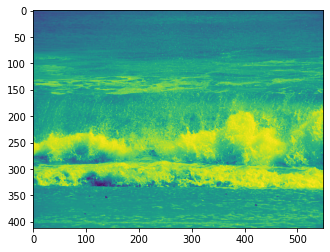

In [59]:
plt.imshow(test_image)

In [60]:
test_image = preprocess_image_improved(test_image)
test_image = np.array([(test_image)])
test_image = test_image.reshape(1,300,300,3)

In [61]:
test_image2 = preprocess_image_improved(test_image2)
test_image2 = np.array([(test_image2)])
test_image2 = test_image2.reshape(1,300,300,3)

In [64]:
y_cat

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [62]:
model.predict(test_image)

1/1 [==============================] - 0s 18ms/step


array([[0.9230295 , 0.00173655, 0.07523399]], dtype=float32)

In [63]:
model.predict(test_image2)

1/1 [==============================] - 0s 17ms/step


array([[9.4043172e-04, 9.9801588e-01, 1.0436607e-03]], dtype=float32)